In [9]:
import pandas as pd
import numpy as np
import itertools, random

from jenga.tasks.reviews import VideogameReviewsTask

from jenga.cleaning.ppp import PipelineWithPPP
from jenga.cleaning.autoclean import AutoClean

from jenga.corruptions.numerical import SwappedValues, Outliers, Scaling
from jenga.corruptions.text import BrokenCharacters
from jenga.corruptions.missing import ( MissingValuesHighEntropy, 
                                  MissingValuesLowEntropy, 
                                  MissingValues
                                )

import random

random.seed(42)

corruptions = {
    'numeric':[Outliers, Scaling],
    'text': [BrokenCharacters],
    'missing': [MissingValuesHighEntropy, 
                MissingValuesLowEntropy, 
                MissingValues]
}

def get_random_perturbation(numerical_columns, 
                            categorical_columns, 
                            fractions=[.5, .7, .9]):
    '''
    Returns a random perturbation, chosen from either a numeric (swapping, outlier, scaling)
    or missingness
    '''
    random_fraction = random.choice(fractions)
    missingness = random.choice(['MCAR', 'MAR', 'MNAR'])
    rand_column = random.choice(categorical_columns)
    return MissingValues(random_fraction, rand_column, None, missingness)


In [10]:
task = VideogameReviewsTask()

results = []

while task.advance_current_week():

    print("----- Week", task.current_week(), "-----")

    train_data = task.current_accumulated_train_data()
    train_labels = task.current_accumulated_train_labels()

    model = task.fit_baseline_model(train_data, train_labels)
    
    ac = AutoClean(train_data, 
                   train_labels, 
                   model, 
                   numerical_columns=task.numerical_attributes, 
                   categorical_columns=task.categorical_attributes,
                   text_columns=task.text_attributes
                  )
    
    test_data = task.current_test_data()
    predictions = model.predict_proba(test_data)
    clean_data_test_score = task.score_on_current_test_data(predictions)
    print("\tAUC on test data", clean_data_test_score)
    
    rand_perturbation = get_random_perturbation(task.numerical_attributes,
                                            task.categorical_attributes)
    corrupted_test_data = rand_perturbation(test_data.copy(deep=True))
    
    cleaned_test_data, ppp_score, cleaned_scores = ac(corrupted_test_data.copy(deep=True))
    cleaned_predictions = model.predict_proba(cleaned_test_data)
    cleaned_data_test_score = task.score_on_current_test_data(cleaned_predictions)
    
    corrupted_predictions = model.predict_proba(corrupted_test_data)
    corrupted_data_test_score = task.score_on_current_test_data(corrupted_predictions)
    
    results.append({
        'perturbation': rand_perturbation,
        'clean_data_test_score': clean_data_test_score,
        'corrupted_data_test_score': corrupted_data_test_score,
        'cleaned_data_test_score': cleaned_data_test_score,
        'ppp_score': ppp_score,
        'cleaned_scores': cleaned_scores
    })
    print(f"\tScores for test data corrupted with {rand_perturbation.__dict__}")
    for k,v in results[-1].items():
        print(f'\t\t{k}:{v}')


----- Week 0 -----
Generating perturbed training data on 7798 rows ...
	... perturbation 0/78: swapped, col ('star_rating', 'total_votes'), fraction: 0.5
	... perturbation 1/78: swapped, col ('vine', 'verified_purchase'), fraction: 0.5
	... perturbation 2/78: scaling, col ['total_votes'], fraction: 0.5
	... perturbation 3/78: outlier, col ['total_votes'], fraction: 0.5
	... perturbation 4/78: missing_MCAR, col total_votes, fraction: 0.5
	... perturbation 5/78: missing_MAR, col total_votes, fraction: 0.5
	... perturbation 6/78: missing_MNAR, col total_votes, fraction: 0.5
	... perturbation 7/78: missing_MCAR, col verified_purchase, fraction: 0.5
	... perturbation 8/78: missing_MAR, col verified_purchase, fraction: 0.5
	... perturbation 9/78: missing_MNAR, col verified_purchase, fraction: 0.5
	... perturbation 10/78: missing_high_entropy, col ['verified_purchase'], fraction: 0.5
	... perturbation 11/78: missing_low_entropy, col ['product_parent'], fraction: 0.5
	... perturbation 12/78: b

/Users/felix/code/jenga/jenga/cleaning/autoclean.py:46: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  best_cleaning_idx = pd.Series(cleaner_results).argmax()


	Scores for test data corrupted with {'column': 'vine', 'fraction': 0.9, 'na_value': None, 'missingness': 'MAR'}
		perturbation:<jenga.corruptions.missing.MissingValues object at 0x1374893c8>
		clean_data_test_score:0.9703665235677374
		corrupted_data_test_score:0.962073116001136
		cleaned_data_test_score:0.9703583811540483
		ppp_score:0.924870344936644
		cleaned_scores:[0.9729862345514515]
----- Week 1 -----
Generating perturbed training data on 15530 rows ...
	... perturbation 0/78: swapped, col ('star_rating', 'total_votes'), fraction: 0.5
	... perturbation 1/78: swapped, col ('vine', 'product_id'), fraction: 0.5
	... perturbation 2/78: scaling, col ['total_votes'], fraction: 0.5
	... perturbation 3/78: outlier, col ['total_votes'], fraction: 0.5
	... perturbation 4/78: missing_MCAR, col total_votes, fraction: 0.5
	... perturbation 5/78: missing_MAR, col total_votes, fraction: 0.5
	... perturbation 6/78: missing_MNAR, col total_votes, fraction: 0.5
	... perturbation 7/78: missing_MC

/Users/felix/code/jenga/jenga/cleaning/autoclean.py:46: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  best_cleaning_idx = pd.Series(cleaner_results).argmax()


	Scores for test data corrupted with {'column': 'verified_purchase', 'fraction': 0.5, 'na_value': None, 'missingness': 'MNAR'}
		perturbation:<jenga.corruptions.missing.MissingValues object at 0x1345f7208>
		clean_data_test_score:0.9687432677693999
		corrupted_data_test_score:0.9635605199864248
		cleaned_data_test_score:0.9687432677693999
		ppp_score:0.9723463548747695
		cleaned_scores:[0.9727485724644248]
----- Week 2 -----
Generating perturbed training data on 22305 rows ...
	... perturbation 0/78: swapped, col ('star_rating', 'total_votes'), fraction: 0.5
	... perturbation 1/78: swapped, col ('verified_purchase', 'product_id'), fraction: 0.5
	... perturbation 2/78: scaling, col ['total_votes'], fraction: 0.5
	... perturbation 3/78: outlier, col ['total_votes'], fraction: 0.5
	... perturbation 4/78: missing_MCAR, col total_votes, fraction: 0.5
	... perturbation 5/78: missing_MAR, col total_votes, fraction: 0.5
	... perturbation 6/78: missing_MNAR, col total_votes, fraction: 0.5
	... 

/Users/felix/code/jenga/jenga/cleaning/autoclean.py:46: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  best_cleaning_idx = pd.Series(cleaner_results).argmax()


	Scores for test data corrupted with {'column': 'review_id', 'fraction': 0.7, 'na_value': None, 'missingness': 'MAR'}
		perturbation:<jenga.corruptions.missing.MissingValues object at 0x10a9b4eb8>
		clean_data_test_score:0.9620343554861981
		corrupted_data_test_score:0.9620343554861981
		cleaned_data_test_score:0.9620343554861981
		ppp_score:0.9648189958682131
		cleaned_scores:[0.9648189958682131]


In [11]:
results

[{'perturbation': <jenga.corruptions.missing.MissingValues at 0x1374893c8>,
  'clean_data_test_score': 0.9703665235677374,
  'corrupted_data_test_score': 0.962073116001136,
  'cleaned_data_test_score': 0.9703583811540483,
  'ppp_score': 0.924870344936644,
  'cleaned_scores': [0.9729862345514515]},
 {'perturbation': <jenga.corruptions.missing.MissingValues at 0x1345f7208>,
  'clean_data_test_score': 0.9687432677693999,
  'corrupted_data_test_score': 0.9635605199864248,
  'cleaned_data_test_score': 0.9687432677693999,
  'ppp_score': 0.9723463548747695,
  'cleaned_scores': [0.9727485724644248]},
 {'perturbation': <jenga.corruptions.missing.MissingValues at 0x10a9b4eb8>,
  'clean_data_test_score': 0.9620343554861981,
  'corrupted_data_test_score': 0.9620343554861981,
  'cleaned_data_test_score': 0.9620343554861981,
  'ppp_score': 0.9648189958682131,
  'cleaned_scores': [0.9648189958682131]}]

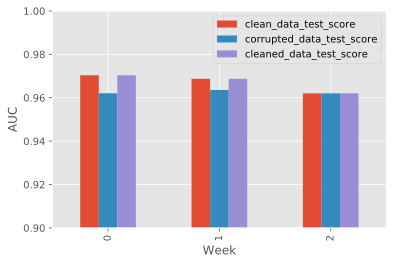

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

pd.DataFrame(results)[[
    'clean_data_test_score',
    'corrupted_data_test_score',
    'cleaned_data_test_score']].plot.bar()
plt.xlabel('Week')
plt.ylabel('AUC')
plt.ylim([.9,1]);
plt.savefig('preliminary_result.pdf')